Researchers have access to large online archives of scientific articles. As a consequence, finding relevant articles has become more difficult. Tagging or topic modelling provides a way to give token of identification to research articles which facilitates recommendation and search process.
Given the abstract and title for a set of research articles, predict the topics for each article included in the test set. 
Note that a research article can possibly have more than 1 topic. The research article abstracts and titles are sourced from the following 6 topics: 
1. Computer Science

2. Physics

3. Mathematics

4. Statistics

5. Quantitative Biology

6. Quantitative Finance

Submissions are evaluated on micro F1 Score between the predicted and observed topics for each article in the test set

In [2]:
import warnings
from pprint import pprint
from time import time
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sys
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer,TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.multiclass import OneVsRestClassifier
from skmultilearn.problem_transform import ClassifierChain
from sklearn.linear_model import LogisticRegression
from skmultilearn.problem_transform import BinaryRelevance
from sklearn.naive_bayes import GaussianNB
from skmultilearn.problem_transform import LabelPowerset
from skmultilearn.adapt import MLkNN
from scipy.sparse import csr_matrix, lil_matrix
from skmultilearn.problem_transform import LabelPowerset
from tqdm import tqdm
from sklearn.metrics import f1_score, make_scorer

In [3]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
from nltk.corpus import wordnet
en_stop = set(nltk.corpus.stopwords.words('english'))
en_stop.update(['zero','one','two','three','four','five','six','seven','eight','nine','ten','may','also','across',
                'among','beside','however','yet','within'])

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\NAIDU\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\NAIDU\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\NAIDU\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [4]:
raw_data = pd.read_csv('data/train.csv')
raw_data.head(2)

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive models allow subject-specific inf...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance and translation invarian...,1,0,0,0,0,0


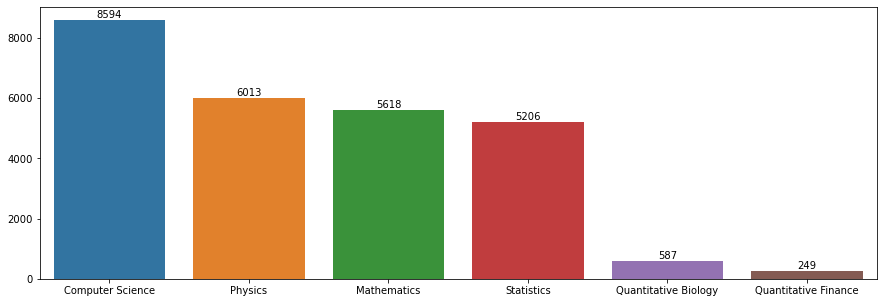

In [7]:
#EDA: to check the composition of classes
data = raw_data.iloc[:,3:]
plt.figure(figsize=(15,5))
lables = data.sum().values
ax = sns.barplot(data.columns,lables)

rects = ax.patches
for rect,lable in zip(rects,lables):
    height = rect.get_height()
    ax.text(rect.get_x()+rect.get_width()/2,height+5,lable,ha='center',va='bottom')


In [4]:
#preprocessing
data = raw_data.copy()

In [5]:
def getPosTagDef(postag):
    try:
        if postag in ['JJ', 'JJR', 'JJS']:
            return wordnet.ADJ
        elif postag in ['RB', 'RBR', 'RBS']:
            return wordnet.ADV
        elif postag in ['NN', 'NNS', 'NNP', 'NNPS']:
            return wordnet.NOUN
        elif postag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            return wordnet.VERB
        else:
            return None
    except:
        print(sys.exc_info()[0])

In [6]:
# except a-zA-Z remove all
re_stop_words = re.compile(r'\b(' + '|'.join(en_stop) + ')\\W', re.I)
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def preprocess(string):
    result=[]
    #clean
    string = re.sub('[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~\n]',' ',string)
    string = re.sub(r'[^a-zA-Z ]','',string)
    #stop words
    string = re_stop_words.sub(' ',string)
    #stemming
    #string = ' '.join([stemmer.stem(x.strip()) for x in string.split()])
    #lemmatize
    pos_tags = nltk.pos_tag(string.split())
    for token,postag in pos_tags:    
        pos = getPosTagDef(postag)
        if pos != None:
              result.append(lemmatizer.lemmatize(token,pos))
        else:
              result.append( lemmatizer.lemmatize(token))
    return ' '.join(result)

data['ABSTRACT'] = data['ABSTRACT'].apply(preprocess)
data.head()

,ID,TITLE,ABSTRACT,Computer Science,Physics,Mathematics,Statistics,Quantitative Biology,Quantitative Finance
0,1,Reconstructing Subject-Specific Effect Maps,Predictive model allow subject specific infere...,1,0,0,0,0,0
1,2,Rotation Invariance Neural Network,Rotation invariance translation invariance gre...,1,0,0,0,0,0
2,3,Spherical polyharmonics and Poisson kernels fo...,introduce develop notion spherical polyharmoni...,0,0,1,0,0,0
3,4,A finite element approximation for the stochas...,stochastic Landau Lifshitz Gilbert LLG equatio...,0,0,1,0,0,0
4,5,Comparative study of Discrete Wavelet Transfor...,Fourier transform infra red FTIR spectrum samp...,1,0,0,1,0,0


In [14]:
#preprocess pipeline
X = data['ABSTRACT']
y = data.iloc[:,3:]

pipe_pre =  Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer())])
'''
pipe_model = Pipeline([('binrel',BinaryRelevance(GaussianNB())),
                            ('clf',ClassifierChain(LogisticRegression())),
                            ('powsetreg',LabelPowerset(LogisticRegression())),
                            ('mlk',MLkNN()),
                            ('powsetgau',LabelPowerset(GaussianNB()))
                           ])
                           '''
classifiers = [
    BinaryRelevance(GaussianNB()),
    #ClassifierChain(LogisticRegression()),
    #LabelPowerset(LogisticRegression()),
    #MLkNN(),
    #LabelPowerset(GaussianNB())
]
check_params = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (100,200),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'tfidf__use_idf': (True, False),
    'tfidf__norm': ('l1', 'l2')
}
for classifier in classifiers:
    pipe = Pipeline([('vect', CountVectorizer()),('tfidf', TfidfTransformer()),('model',classifier)])
    print(classifier)
    with tqdm(total=len(range(4,6))) as bar:
        for cv in tqdm(range(4,6)):
            Gsc = GridSearchCV(estimator=pipe,param_grid=check_params,cv=cv,scoring='f1_micro')
            Gsc.fit(X,y)
            print('score for %d : %3.2f' %(cv,  gridsearch.best_score_))
            print('best_params :', [(k,v) for (k,v) in Gsc.best_params_.items()])
            bar.update(1)


  0%|                                                                                            | 0/2 [00:00<?, ?it/s]

BinaryRelevance(classifier=GaussianNB(), require_dense=[True, True])


  0%|                                                                                            | 0/2 [05:19<?, ?it/s]


KeyboardInterrupt: 

In [21]:
from sklearn.base import TransformerMixin, BaseEstimator
import nltk
from nltk.corpus import wordnet
import re
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas

class preTransformer(BaseEstimator,TransformerMixin):
    def __init__(self):
        self.re_stop_words = re.compile(r'\b(' + '|'.join(en_stop) + ')\\W', re.I)
        self.stemmer = PorterStemmer()
        self.lemmatizer = WordNetLemmatizer()
        pass
        
    def fit(self,df,y=None):
        return self
    
    def transform(self,df,y=None):
        df['ABSTRACT'] = df['ABSTRACT'].apply(self.preprocess)
    
    def getPosTagDef(self,postag):
        if postag in ['JJ', 'JJR', 'JJS']:
            return wordnet.ADJ
        elif postag in ['RB', 'RBR', 'RBS']:
            return wordnet.ADV
        elif postag in ['NN', 'NNS', 'NNP', 'NNPS']:
            return wordnet.NOUN
        elif postag in ['VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ']:
            return wordnet.VERB
        else:
            return None
    def preprocess(self,string):
        result=[]
        #clean
        string = re.sub('[!”#$%&’()*+,-./:;<=>?@[\]^_`{|}~\n]',' ',string)
        string = re.sub(r'[^a-zA-Z ]','',string)
        string = re.sub(r'\b\w{1,3}\b', '', string)
        #stop words
        string = self.re_stop_words.sub(' ',string)
        #stemming
        #string = ' '.join([stemmer.stem(x.strip()) for x in string.split()])
        #lemmatize
        pos_tags = nltk.pos_tag(string.split())
        for token,postag in pos_tags:    
            pos = self.getPosTagDef(postag)
            if pos != None:
                  result.append(self.lemmatizer.lemmatize(token,pos))
            else:
                  result.append( self.lemmatizer.lemmatize(token))
        return ' '.join(result)


In [6]:
newdata = raw_data.copy()
newdata['ABSTRACT'][0]

"  Predictive models allow subject-specific inference when analyzing disease\nrelated alterations in neuroimaging data. Given a subject's data, inference can\nbe made at two levels: global, i.e. identifiying condition presence for the\nsubject, and local, i.e. detecting condition effect on each individual\nmeasurement extracted from the subject's data. While global inference is widely\nused, local inference, which can be used to form subject-specific effect maps,\nis rarely used because existing models often yield noisy detections composed of\ndispersed isolated islands. In this article, we propose a reconstruction\nmethod, named RSM, to improve subject-specific detections of predictive\nmodeling approaches and in particular, binary classifiers. RSM specifically\naims to reduce noise due to sampling error associated with using a finite\nsample of examples to train classifiers. The proposed method is a wrapper-type\nalgorithm that can be used with different binary classifiers in a diagn

In [22]:
pretr = preTransformer()
pretr.fit_transform(newdata)

In [19]:
newdata['ABSTRACT'][0]

'Predictive model allow subject specific inference analyze disease related alteration neuroimaging data Given subject data inference make level global e identifiying condition presence subject local e detect condition effect individual measurement extract subject data global inference widely use local inference use form subject specific effect map rarely use exist model often yield noisy detection compose disperse isolated island article propose reconstruction method name RSM improve subject specific detection predictive modeling approach particular binary classifier RSM specifically aim reduce noise due sample error associate use finite sample example train classifier propose method wrapper type algorithm use different binary classifier diagnostic manner e without information condition presence Reconstruction pose Maximum Posteriori problem prior model whose parameter estimate train data classifier specific fashion Experimental evaluation perform synthetically generate data data Alzhe

In [23]:
newdata['ABSTRACT'][0]

'Predictive model allow subject specific inference analyze disease relate alteration neuroimaging data Given subject data inference make level global identifiying condition presence subject local detect condition effect individual measurement extract subject data global inference widely local inference form subject specific effect rarely exist model often yield noisy detection compose disperse isolate island article propose reconstruction method name improve subject specific detection predictive modeling approach particular binary classifier specifically reduce noise sample error associate finite sample example train classifier propose method wrapper type algorithm different binary classifier diagnostic manner without information condition presence Reconstruction pose Maximum Posteriori problem prior model whose parameter estimate train data classifier specific fashion Experimental evaluation perform synthetically generate data data Alzheimers Disease Neuroimaging Initiative ADNI datab